# Part 1: Text Processing and Exploratory Data Analysis

## 1. Data preparation

In [5]:
# %pip install nltk

In [1]:
import os, string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re

from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

In [2]:
data_path =  os.path.join(os.getcwd(), '../../data/')
doc_path = os.path.join(data_path, 'fashion_products_dataset.json')

data = pd.read_json(doc_path)

data.head(5)

,_id,actual_price,average_rating,brand,category,crawled_at,description,discount,images,out_of_stock,pid,product_details,seller,selling_price,sub_category,title,url
0,fa8e22d6-c0b6-5229-bb9e-ad52eda39a0a,"2,999",3.9,York,Clothing and Accessories,2021-02-10 20:11:51,Yorker trackpants made from 100% rich combed c...,69% off,[https://rukminim1.flixcart.com/image/128/128/...,False,TKPFCZ9EA7H5FYZH,"[{'Style Code': '1005COMBO2'}, {'Closure': 'El...",Shyam Enterprises,921,Bottomwear,Solid Women Multicolor Track Pants,https://www.flipkart.com/yorker-solid-men-mult...
1,893e6980-f2a0-531f-b056-34dd63fe912c,"1,499",3.9,York,Clothing and Accessories,2021-02-10 20:11:52,Yorker trackpants made from 100% rich combed c...,66% off,[https://rukminim1.flixcart.com/image/128/128/...,False,TKPFCZ9EJZV2UVRZ,"[{'Style Code': '1005BLUE'}, {'Closure': 'Draw...",Shyam Enterprises,499,Bottomwear,Solid Men Blue Track Pants,https://www.flipkart.com/yorker-solid-men-blue...
2,eb4c8eab-8206-59d0-bcd1-a724d96bf74f,"2,999",3.9,York,Clothing and Accessories,2021-02-10 20:11:52,Yorker trackpants made from 100% rich combed c...,68% off,[https://rukminim1.flixcart.com/image/128/128/...,False,TKPFCZ9EHFCY5Z4Y,"[{'Style Code': '1005COMBO4'}, {'Closure': 'El...",Shyam Enterprises,931,Bottomwear,Solid Men Multicolor Track Pants,https://www.flipkart.com/yorker-solid-men-mult...
3,3f3f97bb-5faf-57df-a9ff-1af24e2b1045,"2,999",3.9,York,Clothing and Accessories,2021-02-10 20:11:53,Yorker trackpants made from 100% rich combed c...,69% off,[https://rukminim1.flixcart.com/image/128/128/...,False,TKPFCZ9ESZZ7YWEF,"[{'Style Code': '1005COMBO3'}, {'Closure': 'El...",Shyam Enterprises,911,Bottomwear,Solid Women Multicolor Track Pants,https://www.flipkart.com/yorker-solid-men-mult...
4,750caa3d-6264-53ca-8ce1-94118a1d8951,"2,999",3.9,York,Clothing and Accessories,2021-02-10 20:11:53,Yorker trackpants made from 100% rich combed c...,68% off,[https://rukminim1.flixcart.com/image/128/128/...,False,TKPFCZ9EVXKBSUD7,"[{'Style Code': '1005COMBO1'}, {'Closure': 'Dr...",Shyam Enterprises,943,Bottomwear,"Solid Women Brown, Grey Track Pants",https://www.flipkart.com/yorker-solid-men-brow...


1. As a first step, you must pre-process the documents. In particular, for the text fields (title,
description) you should:

- Removing stop words
- Tokenization
- Removing punctuation marks
- Stemming
- and... anything else you think it's needed (bonus point)

In [3]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))
translator = str.maketrans('', '', string.punctuation)

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # Lowercase
    text = text.translate(translator) # Remove punctuation
    text = unidecode(text) # normalize
    tokens = word_tokenize(text) # Tokenization
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words] # Remove stopwords and non-alphabetic tokens
    stemmed_tokens = [stemmer.stem(word) for word in tokens] # Stemming 
    stemmed_tokens = [word for word in stemmed_tokens if len(word) > 2] # Remove short tokens
    return ' '.join(stemmed_tokens)

data['title_clean'] = data['title'].apply(preprocess_text)
data['description_clean'] = data['description'].apply(preprocess_text)

data[['pid', 'title', 'title_clean', 'description_clean']].head(5)

# Replace original columns with cleaned versions
data['title'] = data['title_clean']
data['description'] = data['description_clean']
data.drop(columns=['title_clean', 'description_clean'], inplace=True)

2. Take into account that for future queries, the final output must return (when present) the following information for each of the  elected documents: pid, title, description, brand, category, sub_category, product_details, seller, out_of_stock, selling_price, discount, actual_price, average_rating, url

In [4]:
relevant_columns = [
    'pid', 'title', 'description', 'brand', 
    'category', 'sub_category', 'product_details', 
    'seller', 'out_of_stock', 'selling_price', 
    'discount', 'actual_price', 'average_rating', 'url'
]

available_fields = [f for f in relevant_columns if f in data.columns]
clean_data = data[available_fields].copy()
clean_data.head(5)

,pid,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,url
0,TKPFCZ9EA7H5FYZH,solid women multicolor track pant,yorker trackpant made rich comb cotton give ri...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO2'}, {'Closure': 'El...",Shyam Enterprises,False,921,69% off,"2,999",3.9,https://www.flipkart.com/yorker-solid-men-mult...
1,TKPFCZ9EJZV2UVRZ,solid men blue track pant,yorker trackpant made rich comb cotton give ri...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005BLUE'}, {'Closure': 'Draw...",Shyam Enterprises,False,499,66% off,"1,499",3.9,https://www.flipkart.com/yorker-solid-men-blue...
2,TKPFCZ9EHFCY5Z4Y,solid men multicolor track pant,yorker trackpant made rich comb cotton give ri...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO4'}, {'Closure': 'El...",Shyam Enterprises,False,931,68% off,"2,999",3.9,https://www.flipkart.com/yorker-solid-men-mult...
3,TKPFCZ9ESZZ7YWEF,solid women multicolor track pant,yorker trackpant made rich comb cotton give ri...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO3'}, {'Closure': 'El...",Shyam Enterprises,False,911,69% off,"2,999",3.9,https://www.flipkart.com/yorker-solid-men-mult...
4,TKPFCZ9EVXKBSUD7,solid women brown grey track pant,yorker trackpant made rich comb cotton give ri...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO1'}, {'Closure': 'Dr...",Shyam Enterprises,False,943,68% off,"2,999",3.9,https://www.flipkart.com/yorker-solid-men-brow...


3. Decide how to handle the fields category, sub_category, brand, product_details, and seller during pre-processing. Should they be merged into a single text field, indexed as separate fields in the inverted index or any other alternative? Justify your choice, considering how their distinctiveness may affect retrieval effectiveness. What are pros and cons of each approach?

In [5]:
# --- Product details ---

# 1. Count occurrences of each detail key
details = [{k: v for d in (lst or []) for k, v in d.items()} for lst in clean_data.get("product_details", [])]

cnt = Counter(k for d in details for k in d)
top100 = [k for k,_ in cnt.most_common(100)]

# Top-100 counts table
counts_df = pd.DataFrame(cnt.most_common(100), columns=["detail", "count"])
print(counts_df)

             detail  count
0            Fabric  25959
1        Style Code  25763
2           Pattern  25692
3       Fabric Care  21830
4      Suitable For  19139
..              ...    ...
95         Fastener     12
96  Technology Used     11
97   Type for Flats     11
98        Tip Shape     10
99  Tanning Process     10

[100 rows x 2 columns]


In [6]:
# We will use the top 25 (>2500 products) most common details as separate columns
top_details = top100[:25]

# 2. Create separate columns for each top detail
norm = lambda s: re.sub(r'\W+', '_', s.strip().lower())   # blanks/non-word → _
sub = pd.DataFrame(details).reindex(columns=top_details)
sub.columns = [f"detail_{norm(c)}" for c in sub.columns]

clean_data = clean_data.join(sub)
clean_data.drop(columns=["product_details"], inplace=True)

display(clean_data.head())

,pid,title,description,brand,category,sub_category,seller,out_of_stock,selling_price,discount,...,detail_size,detail_neck_type,detail_country_of_origin,detail_brand_fit,detail_sleeve_type,detail_other_details,detail_model_name,detail_occasion,detail_closure,detail_secondary_color
0,TKPFCZ9EA7H5FYZH,solid women multicolor track pant,yorker trackpant made rich comb cotton give ri...,York,Clothing and Accessories,Bottomwear,Shyam Enterprises,False,921,69% off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Elastic,NaN
1,TKPFCZ9EJZV2UVRZ,solid men blue track pant,yorker trackpant made rich comb cotton give ri...,York,Clothing and Accessories,Bottomwear,Shyam Enterprises,False,499,66% off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Drawstring, Elastic",NaN
2,TKPFCZ9EHFCY5Z4Y,solid men multicolor track pant,yorker trackpant made rich comb cotton give ri...,York,Clothing and Accessories,Bottomwear,Shyam Enterprises,False,931,68% off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Elastic,NaN
3,TKPFCZ9ESZZ7YWEF,solid women multicolor track pant,yorker trackpant made rich comb cotton give ri...,York,Clothing and Accessories,Bottomwear,Shyam Enterprises,False,911,69% off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Elastic,NaN
4,TKPFCZ9EVXKBSUD7,solid women brown grey track pant,yorker trackpant made rich comb cotton give ri...,York,Clothing and Accessories,Bottomwear,Shyam Enterprises,False,943,68% off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Drawstring, Elastic",NaN


In [7]:
def clean_metadata_field(text):
    if not isinstance(text, str):
        return ""
    text = text.lower().translate(translator)
    return text.strip()

metadata_fields = ['category', 'sub_category', 'brand', 'seller']
for field in metadata_fields:
    clean_data[field] = clean_data[field].apply(clean_metadata_field)

details_fields = [c for c in clean_data.columns if c.startswith('detail_')]
for field in details_fields:
    clean_data[field] = clean_data[field].apply(clean_metadata_field)

display(clean_data.head())

,pid,title,description,brand,category,sub_category,seller,out_of_stock,selling_price,discount,...,detail_size,detail_neck_type,detail_country_of_origin,detail_brand_fit,detail_sleeve_type,detail_other_details,detail_model_name,detail_occasion,detail_closure,detail_secondary_color
0,TKPFCZ9EA7H5FYZH,solid women multicolor track pant,yorker trackpant made rich comb cotton give ri...,york,clothing and accessories,bottomwear,shyam enterprises,False,921,69% off,...,,,,,,,,,elastic,
1,TKPFCZ9EJZV2UVRZ,solid men blue track pant,yorker trackpant made rich comb cotton give ri...,york,clothing and accessories,bottomwear,shyam enterprises,False,499,66% off,...,,,,,,,,,drawstring elastic,
2,TKPFCZ9EHFCY5Z4Y,solid men multicolor track pant,yorker trackpant made rich comb cotton give ri...,york,clothing and accessories,bottomwear,shyam enterprises,False,931,68% off,...,,,,,,,,,elastic,
3,TKPFCZ9ESZZ7YWEF,solid women multicolor track pant,yorker trackpant made rich comb cotton give ri...,york,clothing and accessories,bottomwear,shyam enterprises,False,911,69% off,...,,,,,,,,,elastic,
4,TKPFCZ9EVXKBSUD7,solid women brown grey track pant,yorker trackpant made rich comb cotton give ri...,york,clothing and accessories,bottomwear,shyam enterprises,False,943,68% off,...,,,,,,,,,drawstring elastic,


4. Consider the fields out_of_stock, selling_price, discount, actual_price, and average_rating. Decide how these should be handled during pre-processing to use in further search. Should they be indexed as textual terms?

In [8]:
# Convert data types to numeric
clean_data["out_of_stock"] = clean_data["out_of_stock"].astype(int)

clean_data["selling_price"] = clean_data["selling_price"].str.replace(',', '', regex=False)
clean_data["selling_price"] = clean_data["selling_price"].replace('', np.nan)
clean_data["selling_price"] = clean_data["selling_price"].astype(float)

clean_data["discount"] = clean_data["discount"].str.replace('%', '', regex=False)
clean_data["discount"] = clean_data["discount"].str.replace('off', '', regex=False)
clean_data["discount"] = clean_data["discount"].str.replace(' ', '', regex=False)
clean_data["discount"] = clean_data["discount"].replace('', np.nan)
clean_data["discount"] = clean_data["discount"].astype(float)

clean_data["actual_price"] = clean_data["actual_price"].str.replace(',', '', regex=False)
clean_data["actual_price"] = clean_data["actual_price"].replace('', np.nan)
clean_data["actual_price"] = clean_data["actual_price"].astype(float)

clean_data["average_rating"] = clean_data["average_rating"].replace('', np.nan)
clean_data["average_rating"] = clean_data["average_rating"].astype(float)


clean_data.head(5)

num_fields = ['out_of_stock', 'discount', 'selling_price', 'actual_price', 'average_rating']
display(clean_data[num_fields].describe())

,out_of_stock,discount,selling_price,actual_price,average_rating
count,28080.000000,27225.000000,28078.000000,27303.000000,25819.000000
mean,0.058547,50.256896,705.635088,1455.528110,3.627724
std,0.234779,16.887287,549.681489,939.977456,0.663429
min,0.000000,1.000000,99.000000,150.000000,1.000000
25%,0.000000,40.000000,390.000000,849.000000,3.200000
50%,0.000000,53.000000,545.000000,1199.000000,3.800000
75%,0.000000,63.000000,820.000000,1799.000000,4.100000
max,1.000000,87.000000,7999.000000,12999.000000,5.000000


In [9]:
data[150:170]

,_id,actual_price,average_rating,brand,category,crawled_at,description,discount,images,out_of_stock,pid,product_details,seller,selling_price,sub_category,title,url
150,e1d59a35-f6c0-5b74-97eb-036c45d5d625,"3,299",2.7,,Clothing and Accessories,2021-02-10 20:13:00,wear eleg woman tie effect way make look charm...,81% off,[https://rukminim1.flixcart.com/image/128/128/...,False,CTPFVZT38N9RHZTA,[{'Model Name': 'Formal/Casual Printed Polyest...,NextEdgeRetails,599,Clothing Accessories,nulit satin tie cufflink multicolor,https://www.flipkart.com/nu-lite-satin-tie-cuf...
151,13f89ee8-0bae-5fee-a681-cdd4c62c9df2,"2,199",3.8,Man,Clothing and Accessories,2021-02-10 20:13:01,,83% off,[https://rukminim1.flixcart.com/image/128/128/...,False,SWTFYGQ7S4KYESNY,"[{'Color': 'Green'}, {'Fabric': 'Wool Blend'},...",SHAKTICREATION,364,Winter Wear,stripe collar neck casual men green sweater,https://www.flipkart.com/manra-striped-collare...
152,26d4373c-6e5a-5106-bd31-07175e83a8c9,"2,199",3.7,Man,Clothing and Accessories,2021-02-10 20:13:01,manra present stylish wollen poncho shawlscard...,81% off,[https://rukminim1.flixcart.com/image/128/128/...,False,SWTFYHNFFQMQ5PHC,"[{'Color': 'Grey, Black'}, {'Fabric': 'Wool Bl...",SHAKTICREATION,399,Winter Wear,stripe collar neck casual men grey black sweater,https://www.flipkart.com/manra-striped-collare...
153,61c48e7e-05c4-5a16-8a26-3d4747958354,"2,199",2.6,Man,Clothing and Accessories,2021-02-10 20:13:02,,79% off,[https://rukminim1.flixcart.com/image/128/128/...,False,SWTFYHP2QQQYEGRJ,"[{'Color': 'Yellow'}, {'Fabric': 'Wool Blend'}...",SHAKTICREATION,453,Winter Wear,solid neck casual men yellow sweater,https://www.flipkart.com/manra-solid-v-neck-ca...
154,1f7316f2-4ab2-5a18-a3f3-9ad8fbff40d0,"2,199",3.8,Man,Clothing and Accessories,2021-02-10 20:13:02,manra present stylish wollen poncho shawlscard...,78% off,[https://rukminim1.flixcart.com/image/128/128/...,False,SWTFYGREMHZAR3AG,"[{'Color': 'Maroon'}, {'Fabric': 'Wool Blend'}...",SHAKTICREATION,464,Winter Wear,stripe neck casual men maroon sweater,https://www.flipkart.com/manra-striped-v-neck-...
155,eb4d525c-11c2-56b3-b8dc-82b9c6031718,"2,199",3.7,Man,Clothing and Accessories,2021-02-10 20:13:03,,82% off,[https://rukminim1.flixcart.com/image/128/128/...,False,SWTFYGQHYZWGHJ6S,"[{'Color': 'Grey'}, {'Fabric': 'Wool Blend'}, ...",SHAKTICREATION,388,Winter Wear,stripe collar neck casual men grey sweater,https://www.flipkart.com/manra-striped-collare...
156,cfb0efc6-c8f3-5ccf-bc14-a2bd02b7fe4f,"2,199",2.6,Man,Clothing and Accessories,2021-02-10 20:13:03,,81% off,[https://rukminim1.flixcart.com/image/128/128/...,False,SWTFYGRSFPU6EZJZ,"[{'Color': 'Blue'}, {'Fabric': 'Wool Blend'}, ...",SHAKTICREATION,399,Winter Wear,stripe neck casual men blue sweater,https://www.flipkart.com/manra-striped-v-neck-...
157,e16ea8d9-97cf-5308-9ea6-4ee852e46077,"2,199",4.3,Man,Clothing and Accessories,2021-02-10 20:13:03,,81% off,[https://rukminim1.flixcart.com/image/128/128/...,False,SWTFYGS7GFGWVX4J,"[{'Color': 'Orange'}, {'Fabric': 'Wool Blend'}...",SHAKTICREATION,399,Winter Wear,stripe neck casual women orang sweater,https://www.flipkart.com/manra-striped-v-neck-...
158,237c1d76-fd13-5fb8-9af3-39b2c7b35aae,"2,199",3,Man,Clothing and Accessories,2021-02-10 20:13:04,manra present stylish wollen poncho shawlscard...,77% off,[https://rukminim1.flixcart.com/image/128/128/...,False,SWTFYQQ5Z7VT4CFH,"[{'Color': 'Purple'}, {'Fabric': 'Wool Blend'}...",SHAKTICREATION,499,Winter Wear,solid neck casual men purpl sweater,https://www.flipkart.com/manra-solid-v-neck-ca...
159,07d8ca96-62b6-5186-8c7f-54984a016de1,"2,199",2.6,Man,Clothing and Accessories,2021-02-10 20:13:04,,77% off,[https://rukminim1.flixcart.com/image/128/128/...,False,SWTFYHPQGHQDHKHY,"[{'Color': 'Beige'}, {'Fabric': 'Wool Blend'},...",SHAKTICREATION,499,Winter Wear,solid neck casual men beig sweater,https://www.flipkart.com/manra-solid-v-neck-ca...


In [10]:
clean_data[150:170]

,pid,title,description,brand,category,sub_category,seller,out_of_stock,selling_price,discount,...,detail_size,detail_neck_type,detail_country_of_origin,detail_brand_fit,detail_sleeve_type,detail_other_details,detail_model_name,detail_occasion,detail_closure,detail_secondary_color
150,CTPFVZT38N9RHZTA,nulit satin tie cufflink multicolor,wear eleg woman tie effect way make look charm...,,clothing and accessories,clothing accessories,nextedgeretails,0,599.0,81.0,...,,,,,,,formalcasual printed polyester necktie set wit...,,,
151,SWTFYGQ7S4KYESNY,stripe collar neck casual men green sweater,,man,clothing and accessories,winter wear,shakticreation,0,364.0,83.0,...,,,india,,,,,,zipper,
152,SWTFYHNFFQMQ5PHC,stripe collar neck casual men grey black sweater,manra present stylish wollen poncho shawlscard...,man,clothing and accessories,winter wear,shakticreation,0,399.0,81.0,...,,,india,,,,,,zipper,
153,SWTFYHP2QQQYEGRJ,solid neck casual men yellow sweater,,man,clothing and accessories,winter wear,shakticreation,0,453.0,79.0,...,,,india,,,,,,no closure,
154,SWTFYGREMHZAR3AG,stripe neck casual men maroon sweater,manra present stylish wollen poncho shawlscard...,man,clothing and accessories,winter wear,shakticreation,0,464.0,78.0,...,,,india,,,,,,no closure,
155,SWTFYGQHYZWGHJ6S,stripe collar neck casual men grey sweater,,man,clothing and accessories,winter wear,shakticreation,0,388.0,82.0,...,,,india,,,,,,zipper,
156,SWTFYGRSFPU6EZJZ,stripe neck casual men blue sweater,,man,clothing and accessories,winter wear,shakticreation,0,399.0,81.0,...,,,india,,,,,,no closure,
157,SWTFYGS7GFGWVX4J,stripe neck casual women orang sweater,,man,clothing and accessories,winter wear,shakticreation,0,399.0,81.0,...,,,india,,,,,,no closure,
158,SWTFYQQ5Z7VT4CFH,solid neck casual men purpl sweater,manra present stylish wollen poncho shawlscard...,man,clothing and accessories,winter wear,shakticreation,0,499.0,77.0,...,,,india,,,,,,no closure,
159,SWTFYHPQGHQDHKHY,solid neck casual men beig sweater,,man,clothing and accessories,winter wear,shakticreation,0,499.0,77.0,...,,,india,,,,,,no closure,


In [ ]:
# Export cleaned data
clean_data.to_csv(os.path.join(data_path, 'fashion_products_cleaned.csv'), index=False)

## 2. Exploratory Data Analysis

When working with data, it is important to have a better understanding of the content and some statistics. Provide an exploratory data analysis to describe the dataset you are working on in this project and explain the decisions made for the analysis. For example, word counting distribution, average sentence length, vocabulary size, ranking of products based on rating, price, discount, top sellers and brands, out_of_stock distribution, word clouds for the most frequent words, and entity recognition. Feel free to do the exploratory analysis and report your findings in the report.

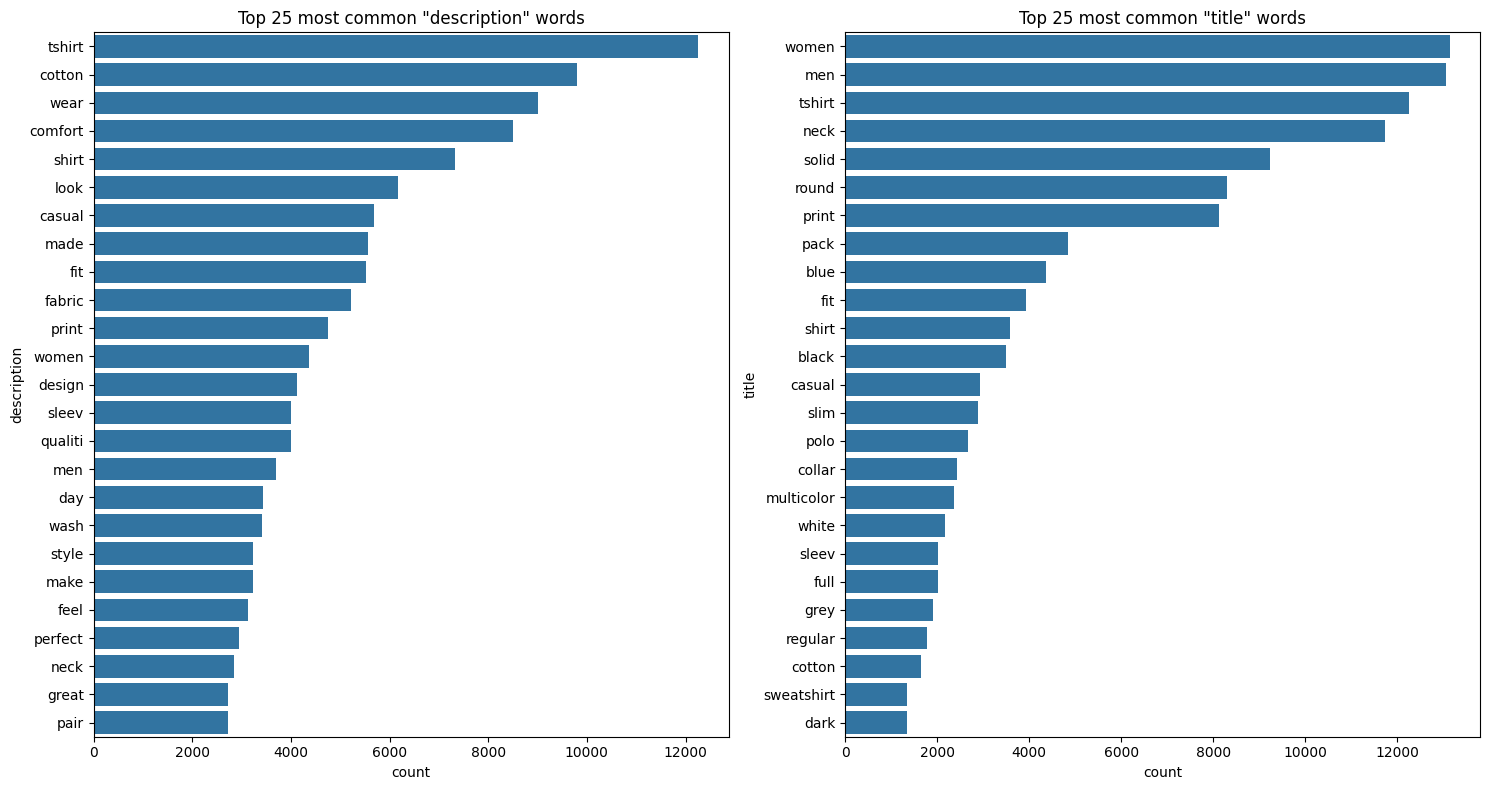

In [12]:
r = 25

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
tmp = pd.DataFrame(clean_data['description'].str.split().explode().value_counts().sort_values(ascending=False)).reset_index()
sns.barplot(data=tmp[:r], y='description', x='count')
plt.title('Top 25 most common "description" words')

plt.subplot(1, 2, 2)
tmp = pd.DataFrame(clean_data['title'].str.split().explode().value_counts().sort_values(ascending=False)).reset_index()
sns.barplot(data=tmp[:r], y='title', x='count')
plt.title('Top 25 most common "title" words')

plt.tight_layout()
plt.show()

In [ ]:
print(f'Average sentence length: {clean_data['description'].apply(lambda x: len(x.split())).mean():.2f} words')

Average sentence length: 17.93 words


In [ ]:
print(f'Vocabulary size is {clean_data['description'].str.split().explode().nunique()} words') # only from description field

Vocabulary size is 5446 words


In [ ]:
# Missing values per column
missing = clean_data.isna().sum().sort_values(ascending=False)
display(missing.to_frame("missing"))

,missing
average_rating,2261
discount,855
actual_price,777
selling_price,2
detail_country_of_origin,0
detail_reversible,0
detail_color,0
detail_brand_color,0
detail_sales_package,0
detail_generic_name,0


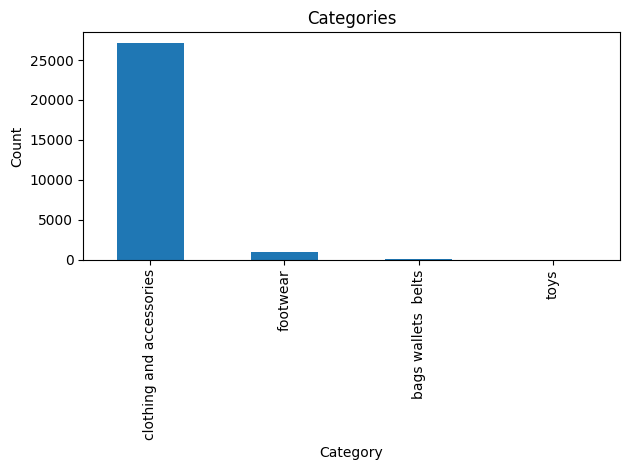

In [ ]:
# Different categories
cats = clean_data["category"].value_counts()
plt.figure()
cats.plot(kind="bar")
plt.title("Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### Numeric columns

In [ ]:
# Out of stock ratio
ratio = (clean_data["out_of_stock"] == 1).mean()
print(f'Out of stock ratio: {ratio:.2%}')

Out of stock ratio: 5.85%


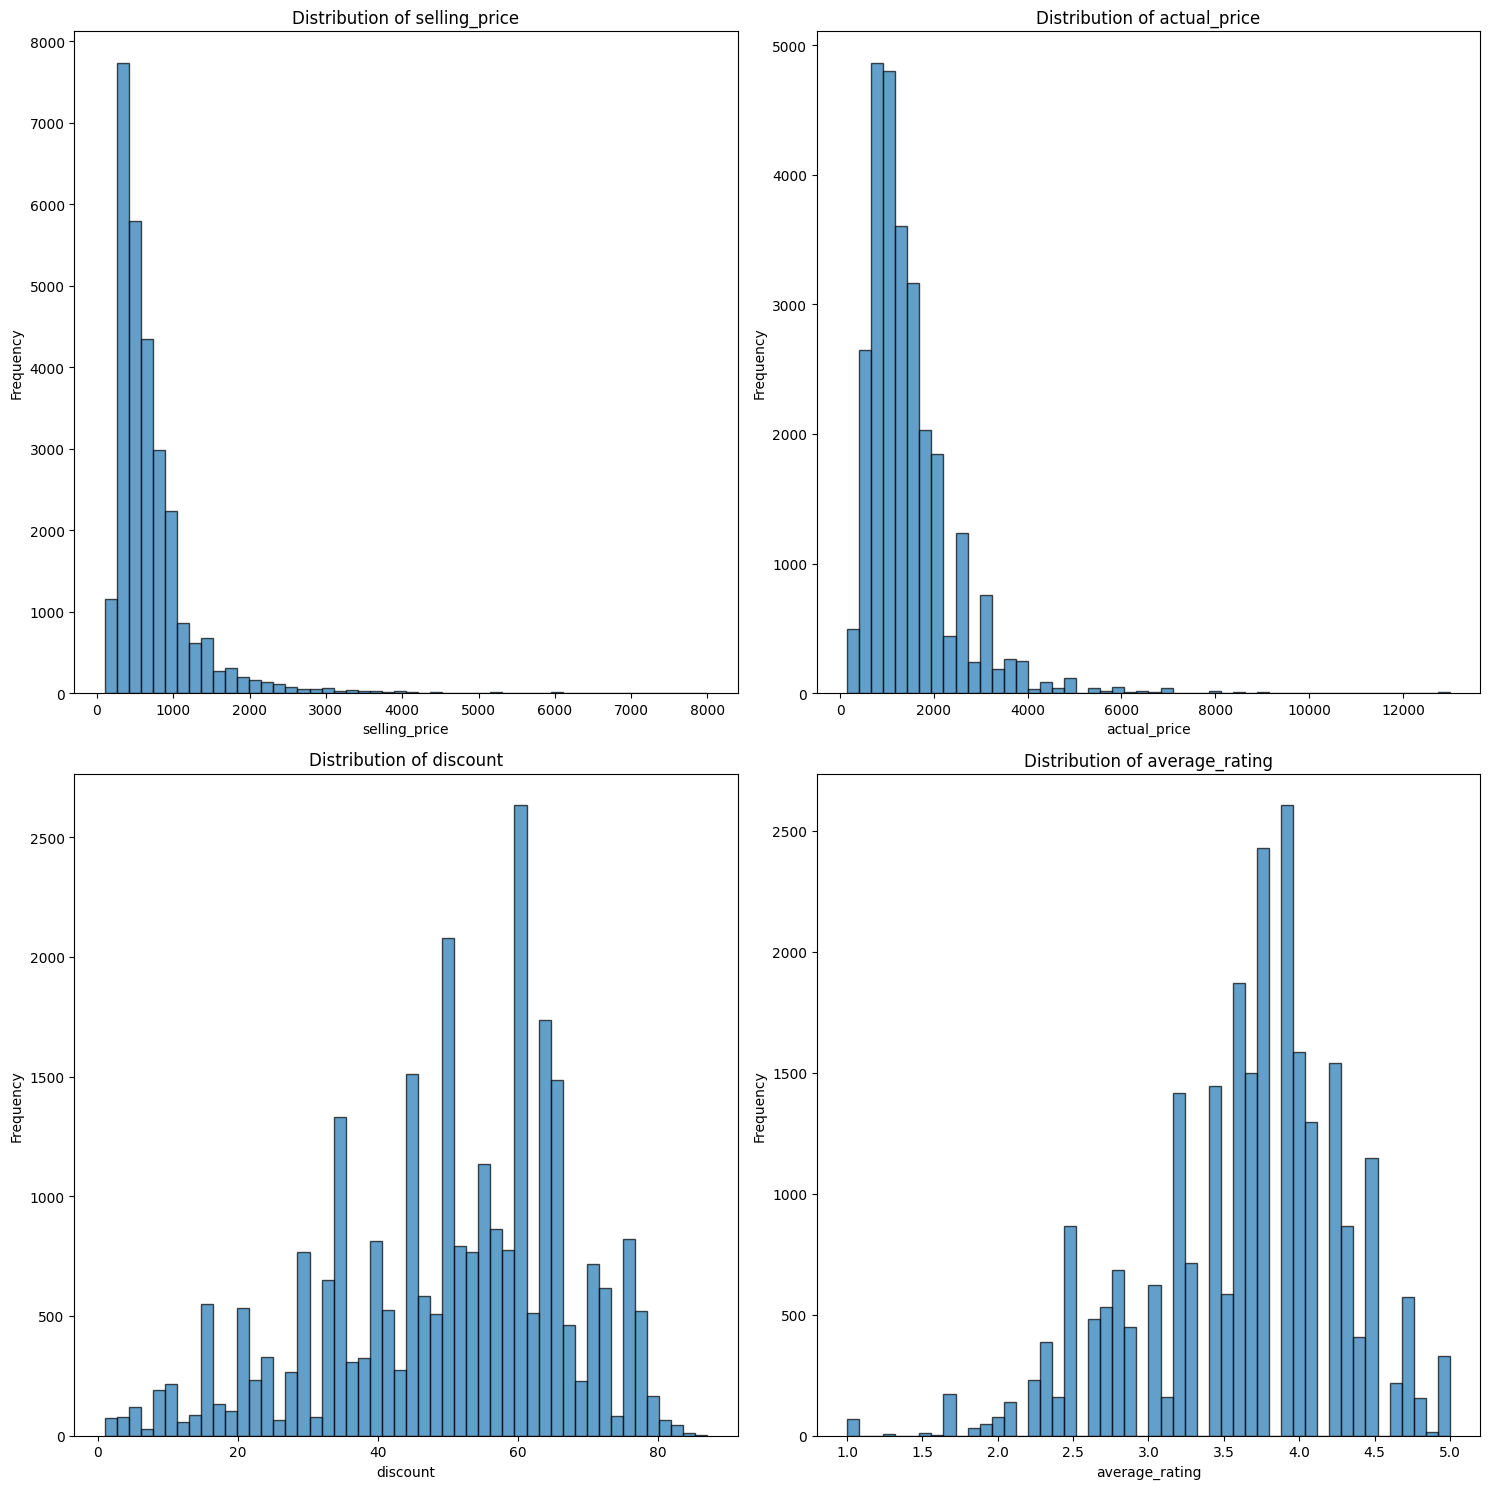

In [ ]:
# Distributions of numerical fields
num_fields = ['selling_price', 'actual_price', 'discount', 'average_rating']

plt.figure(figsize=(15, 15))
for i, col in enumerate(num_fields, start=1):
    plt.subplot(2, 2, i)
    # clean_data[col].dropna().plot(kind='hist', bins=50, edgecolor='black', alpha=0.7)
    plt.hist(clean_data[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
plt.show()

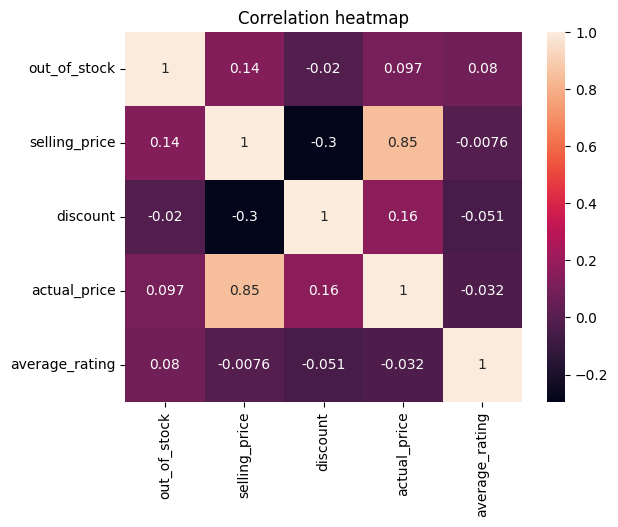

In [ ]:
corr_matrix = clean_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation heatmap")
plt.show()

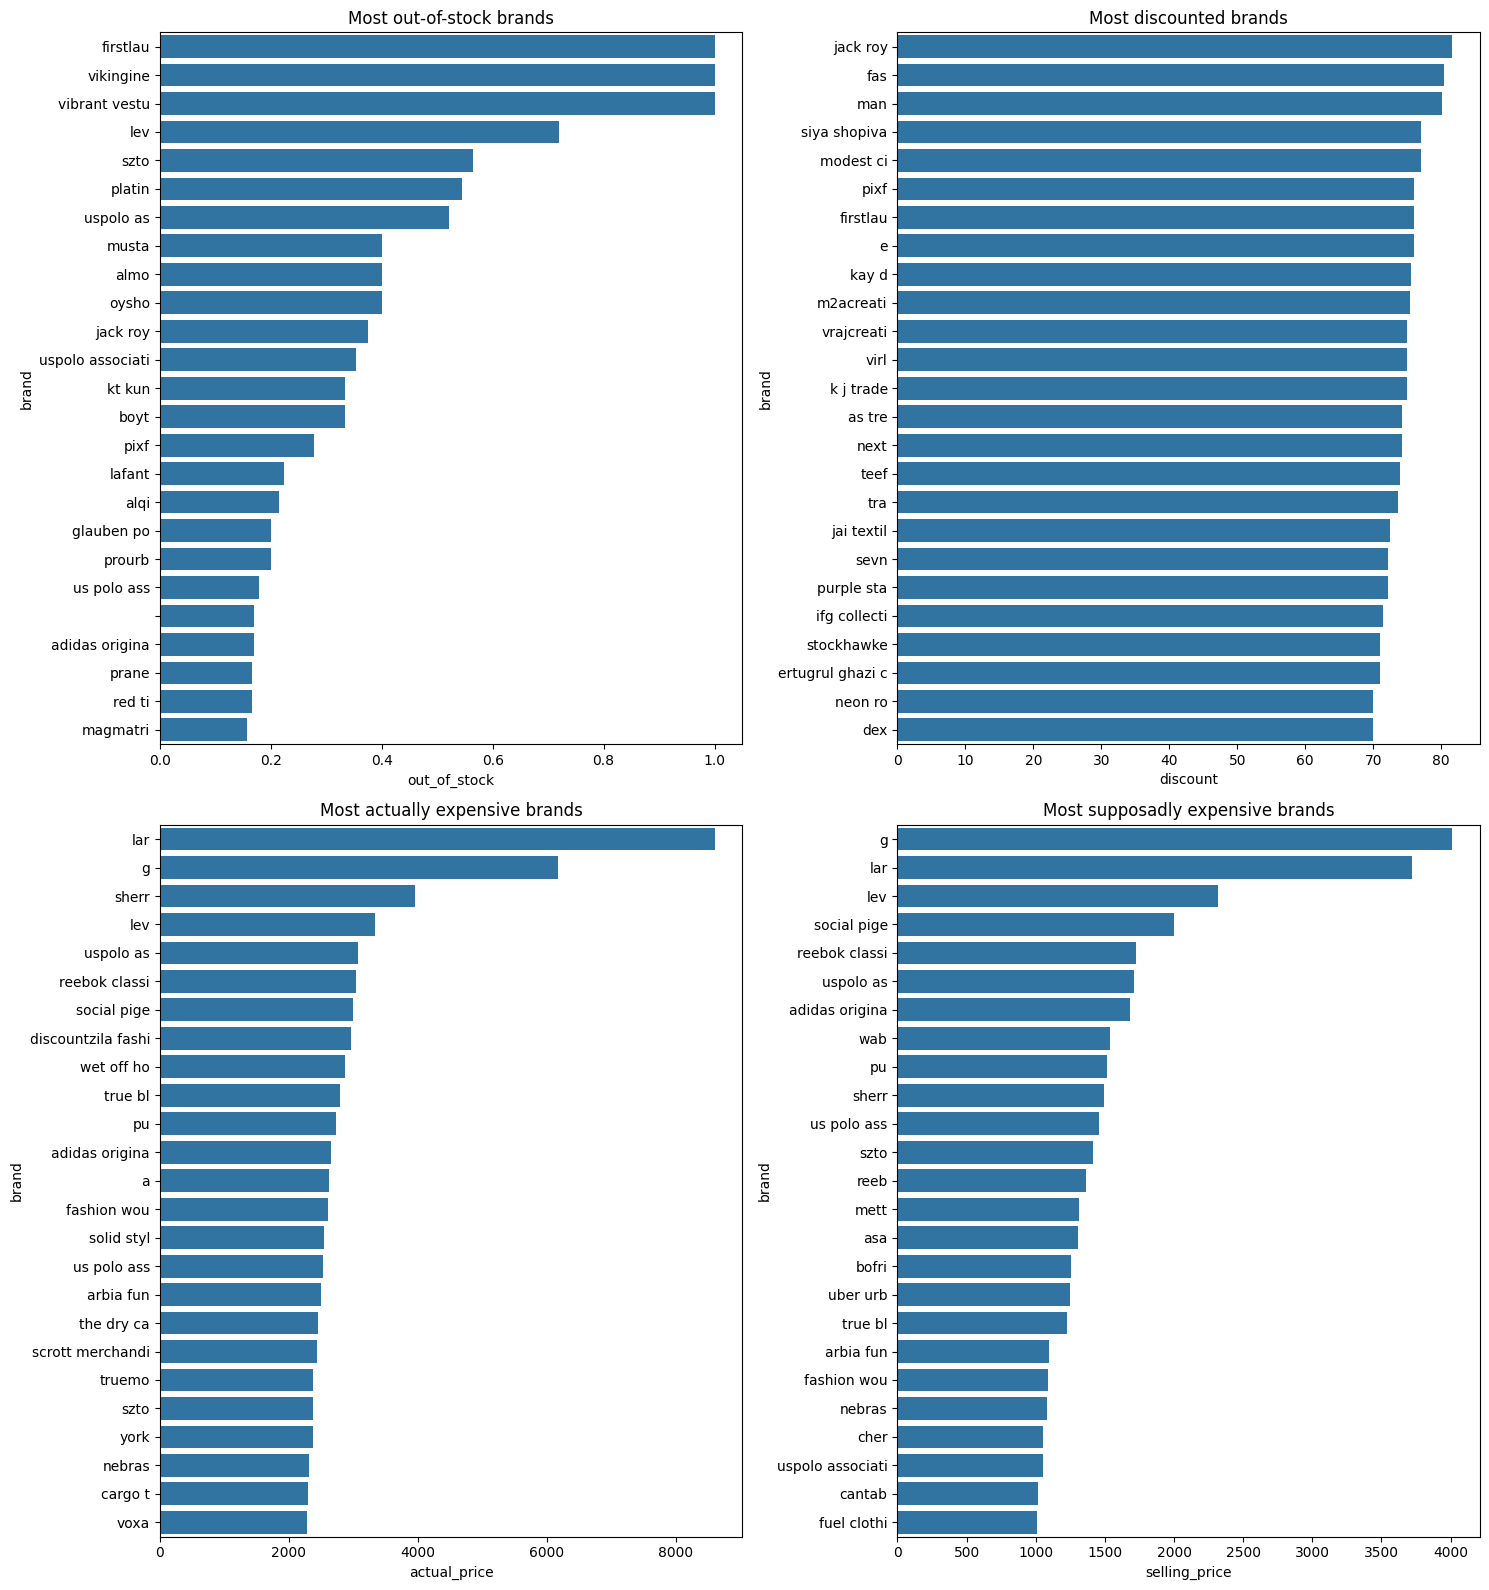

In [ ]:
plt.figure(figsize=(15, 16))

tmp = clean_data.groupby('brand').mean(numeric_only=True)

plt.subplot(2, 2, 1)
sns.barplot(data=tmp.sort_values('out_of_stock', ascending=False).reset_index()[:r], y='brand', x='out_of_stock')
plt.title('Most out-of-stock brands')

plt.subplot(2, 2, 2)
sns.barplot(data=tmp.sort_values('discount', ascending=False).reset_index()[:r], y='brand', x='discount')
plt.title('Most discounted brands')

plt.subplot(2, 2, 3)
sns.barplot(data=tmp.sort_values('actual_price', ascending=False).reset_index()[:r], y='brand', x='actual_price')
plt.title('Most actually expensive brands')

plt.subplot(2, 2, 4)
sns.barplot(data=tmp.sort_values('selling_price', ascending=False).reset_index()[:r], y='brand', x='selling_price')
plt.title('Most supposadly expensive brands')

plt.tight_layout()
plt.show()